In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
PWD = r"C:\Users\Desktop\Sales"
preprocessed_data_file = "all_data_lag.csv"
test_file = os.path.join(PWD, "test.csv")

test_df = pd.read_csv(test_file)
all_data = pd.read_csv(os.path.join(PWD, preprocessed_data_file))

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
def rmse(vec1, vec2):
    return sqrt(mean_squared_error(vec1, vec2))

In [5]:
all_data = downcast_dtypes(all_data)

In [6]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_lag-01,target_shop_lag-01,target_item_lag-01,target_lag-02,target_shop_lag-02,target_item_lag-02,...,date_shop_avg_target_lag-02,date_shop_avg_target_lag-03,date_shop_avg_target_lag-06,date_shop_avg_target_lag-12,date_item_category_avg_target_lag-01,date_shop_item_category_avg_target_lag-01,item_shop_first_sale,item_first_sale,month,days
0,54,10297,12,4.0,3.0,10055.0,42.0,0.0,7978.0,2.0,...,0.9863,0.0000,0.0000,0.0,0.2340,0.6010,2,2,0,31
1,54,10296,12,3.0,0.0,10055.0,24.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0,0.2438,0.5520,1,1,0,31
2,54,10298,12,14.0,21.0,10055.0,369.0,119.0,7978.0,1309.0,...,0.9863,0.8306,0.0000,0.0,0.3090,0.9520,3,3,0,31
3,54,10300,12,3.0,1.0,10055.0,54.0,31.0,7978.0,361.0,...,0.9863,0.8306,0.0000,0.0,0.2340,0.6010,3,3,0,31
4,54,10284,12,1.0,0.0,10055.0,4.0,0.0,7978.0,3.0,...,0.9863,0.8306,0.8594,0.0,0.1383,0.4553,10,10,0,31


In [7]:
target_date = 34

In [8]:
val_date = 33

In [9]:
train_X = all_data[all_data["date_block_num"] < val_date].copy()
train_y = train_X["target"]
train_X_date_block_num = train_X["date_block_num"]
train_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [10]:
test_X = all_data[all_data['date_block_num'] == target_date].copy()
test_X.head()
test_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [11]:
val_X = all_data[all_data["date_block_num"] == val_date].copy()
val_y = val_X["target"]
val_X_date_block_num = val_X["date_block_num"]
val_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [12]:
from sklearn.ensemble import RandomForestRegressor


In [13]:
estimators = 40

rf_clf = RandomForestRegressor(n_estimators=estimators, criterion="mse", 
                               max_features="sqrt",
                               n_jobs=4, verbose=1, random_state=1)

rf_clf.fit(train_X, train_y.clip(0,20))
rf_pred_val_y = rf_clf.predict(val_X)

r = rmse(rf_pred_val_y, val_y.values)
print("RMSE:", r)


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 11.8min finished


RMSE: 2.4957548812576587


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.3s finished


In [14]:
r = rmse(rf_pred_val_y.clip(0,20), val_y.values.clip(0,20))
print("RMSE:", r)

RMSE: 0.9681034856185063


In [15]:
a = np.hstack([val_y.values.reshape(-1,1), rf_pred_val_y.reshape(-1,1)])

level2_train_df = pd.DataFrame(a, columns=["target", "rf"])
level2_train_df.head()

,target,rf
0,1.0,0.000
1,1.0,0.850
2,2.0,0.375
3,1.0,0.100
4,1.0,0.825


In [16]:
level2_train_df.to_csv("level2_train_rf.csv", index=False)

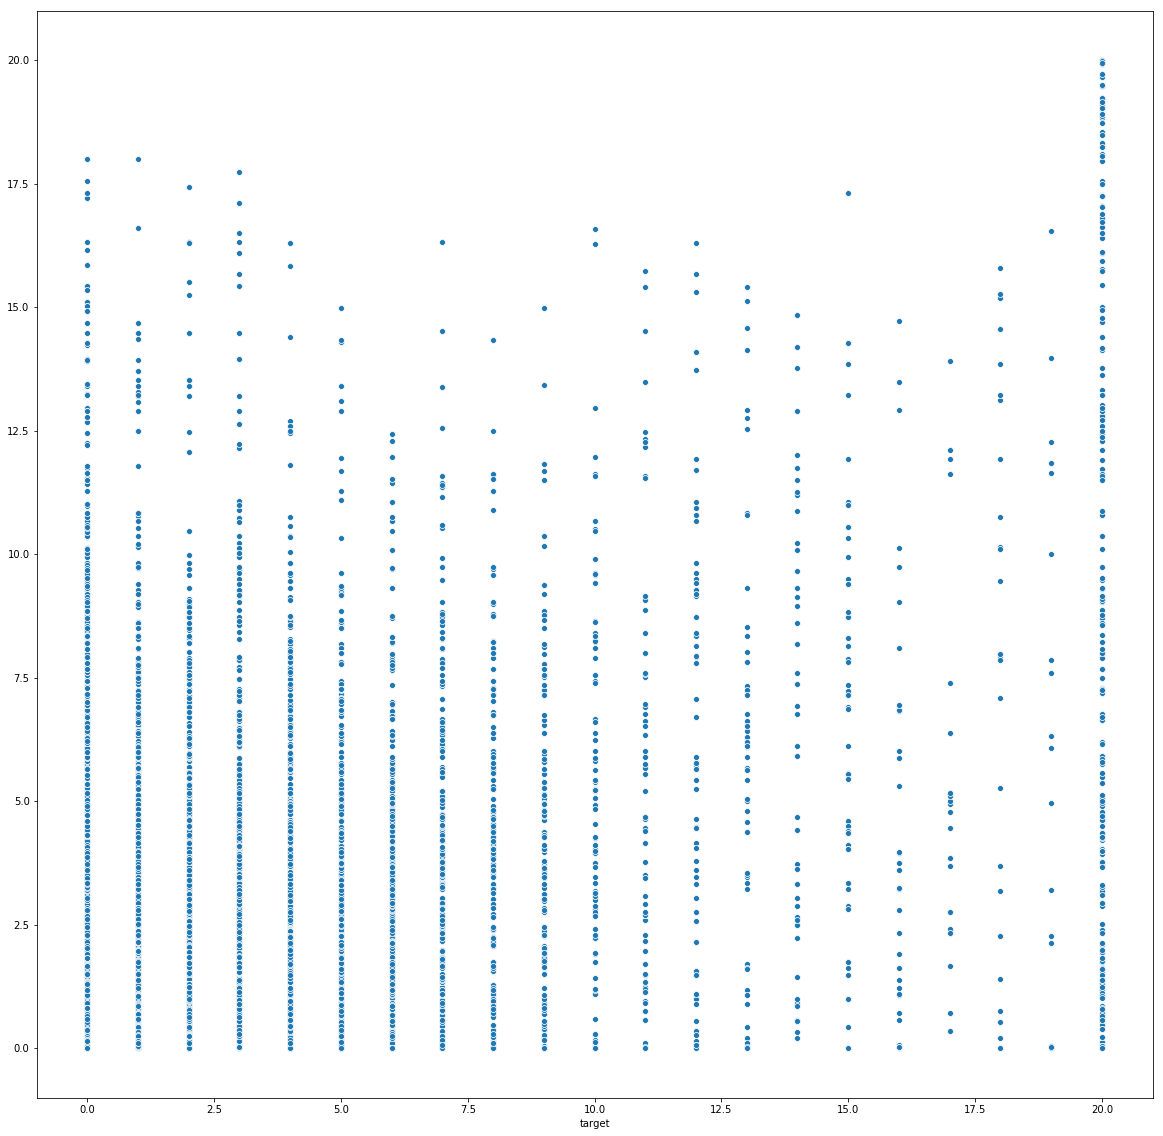

In [17]:
plt.figure(figsize=(20,20))

ax = sns.scatterplot(x=val_y.clip(0,20), y=rf_pred_val_y.clip(0,20))

In [18]:
y_diff_df = pd.Series(val_y.clip(0,20) - rf_pred_val_y.clip(0,20))

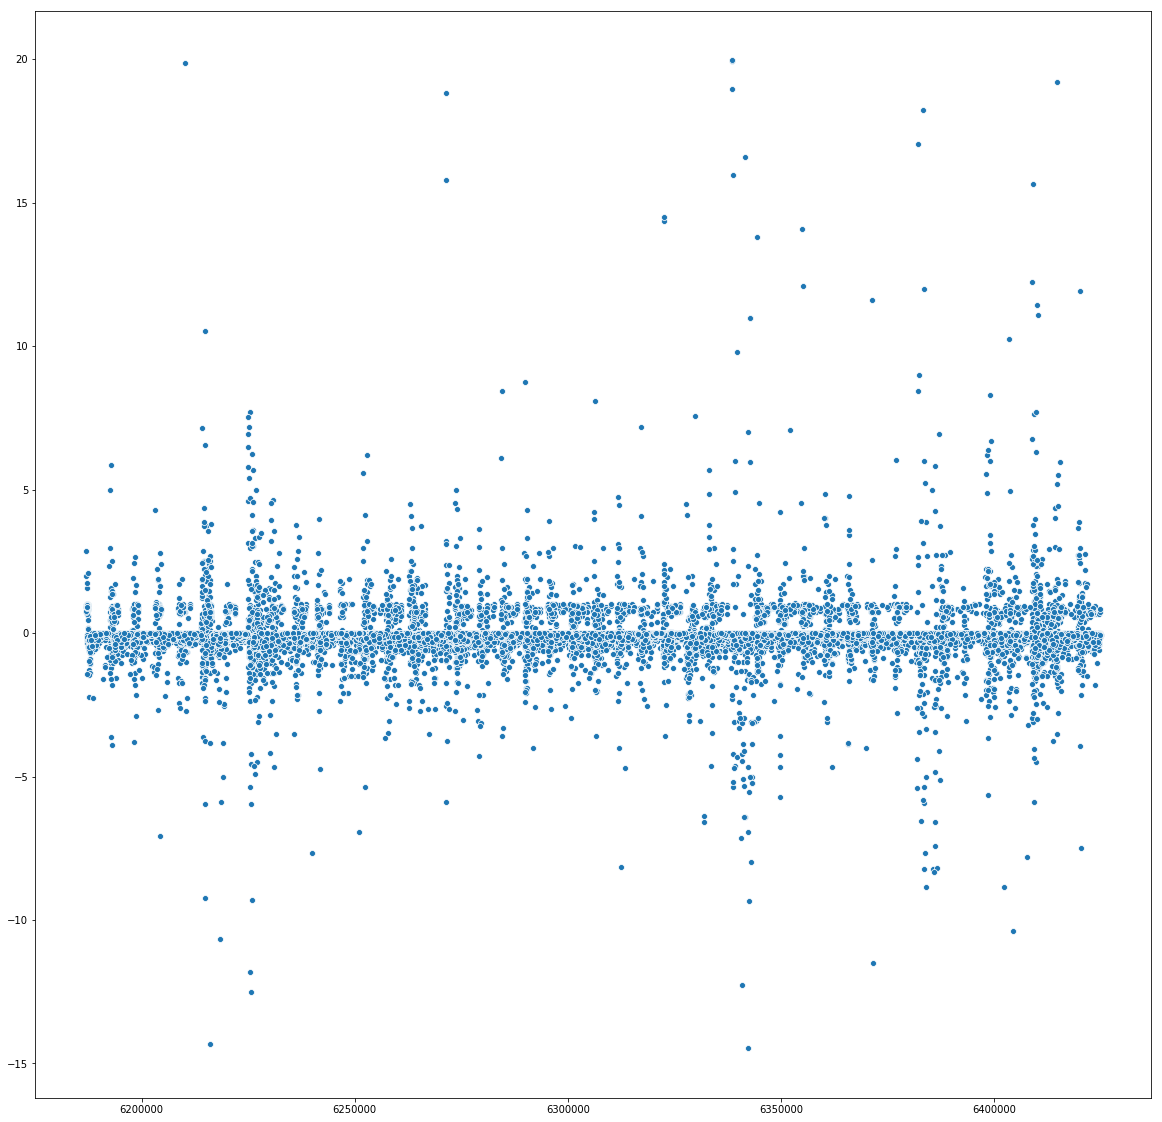

In [19]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=y_diff_df.sample(frac=0.1, random_state=1))

In [20]:
val_X = None
val_y = None
train_X = None
train_y = None
import gc
gc.collect()

26

In [21]:
train_X = all_data[all_data["date_block_num"] < target_date].copy()
train_y = train_X["target"]
train_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [22]:
all_data = None
gc.collect()

7

In [23]:
rf_clf = RandomForestRegressor(n_estimators=estimators, criterion="mse", 
                               max_features="sqrt",
                               n_jobs=4, verbose=1, random_state=1)
rf_clf.fit(train_X, train_y.clip(0,20))
rf_pred_test_y = rf_clf.predict(test_X)

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 12.6min finished
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.3s finished


In [24]:
rf_pred_y_df = pd.DataFrame(rf_pred_test_y.clip(0,20))
rf_pred_y_df.columns = ["item_cnt_month"]
rf_pred_y_df.to_csv("sklearn_rf_prediction.csv", header=True, index=True, index_label="ID")